In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import warnings

sys.path.append(os.getcwd() + "/../src/")

from utils import create_dataset

btc = create_dataset()
btc = btc.reset_index(drop=True)

In [3]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler, SplineTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline

ensemble = VotingRegressor(
    estimators=[
        ('svm', SVR()),
        ('rf', RandomForestRegressor()),
        ('ada', AdaBoostRegressor()),
        ('xgb', XGBRegressor())
    ]
)

pipeline = Pipeline(
    [
        ('power-transformer', PowerTransformer()),
        ('spline', SplineTransformer(n_knots=10)),
        ('ensemble', ensemble)
    ]
)
X, y = btc.drop(columns=['target', 'Date']), btc['target']

In [4]:
ts_cv = TimeSeriesSplit(
    n_splits=100,
    test_size=1
)

res = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    cv=ts_cv,
    scoring=('neg_mean_absolute_percentage_error',)
)

In [5]:
print('---- Mean ----')
print(np.mean(res['test_neg_mean_absolute_percentage_error']))
print('---- Variance ----')
print(np.std(res['test_neg_mean_absolute_percentage_error']))

---- Mean ----
-3.5004243782310818
---- Variance ----
12.60314677914697


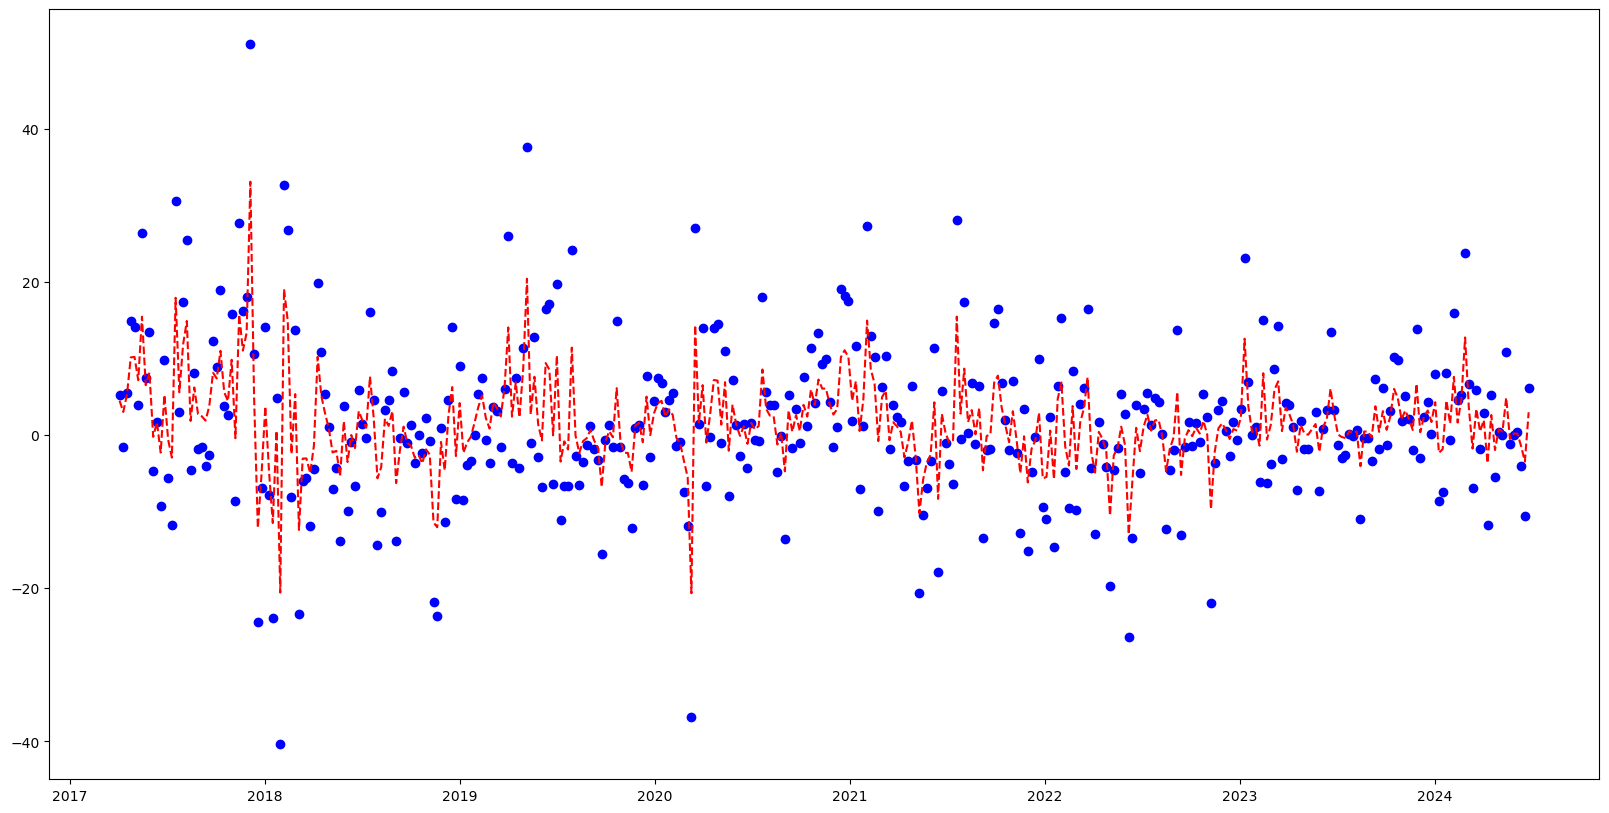

In [6]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    pipeline.fit(X=X, y=y)
    y_pred = pipeline.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(btc['Date'], btc['target'], c='b')
ax.plot(btc['Date'], y_pred, c='r', linestyle='--')
fig.show()

In [7]:
print("----- MAPE -----")
print(f"{mean_absolute_percentage_error(btc['target'], y_pred)}")
print("----- R2 ------")
print(f"{r2_score(btc['target'], y_pred)}")

----- MAPE -----
1.2169978621133564
----- R2 ------
0.7356960251226633
